# Battle of the Neighborhoods Final Project

In this notebook, I will use location data from Foursquare to compare the neighborhood of the Gourmet Ghetto in Berkeley, California with neighborhoods in Chicago. The neighborhoods will be compared according to the most popular venue types and will be clustered using k-means. The deliverable of this project will be a list of the Chicago neighborhoods that are most similar to the neighborhood of the client's current restaurant location. The client's second request is to order the list of these neighborhoods by their distance from the University of Illinois at Chicago.

In [1]:
import numpy as np # used to handle data in vector form
import pandas as pd
from geopy.geocoders import Nominatim # used to get coordinates from address
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans # library for clustering
import folium # library for plotting maps
import matplotlib.pyplot as plt # plotting k means accuracy
from sklearn.cluster import KMeans 
%matplotlib inline

### Chicago Neighborhoods

I was able to obtain coordinate data for the neighborhoods in Chicago from <https://data.cityofchicago.org/Facilities-Geographic-Boundaries/Boundaries-Neighborhoods/bbvz-uum9>. However, we will just use the list of neighborhoods from this list and will get the coordinates from the center of the neighborhood, rather than from the boundaries of the neighborhood.

In [2]:
cn = pd.read_csv("chicago_neighborhoods.csv")
print(cn.shape)
cn.head()

(98, 5)


,the_geom,PRI_NEIGH,SEC_NEIGH,SHAPE_AREA,SHAPE_LEN
0,MULTIPOLYGON (((-87.60670812560372 41.81681377...,Grand Boulevard,BRONZEVILLE,4.849250e+07,28196.837157
1,MULTIPOLYGON (((-87.62760697485348 41.87437097...,Printers Row,PRINTERS ROW,2.162138e+06,6864.247156
2,MULTIPOLYGON (((-87.66706868914602 41.88885187...,United Center,UNITED CENTER,3.252051e+07,23101.363745
3,MULTIPOLYGON (((-87.65833494805533 41.92166144...,Sheffield & DePaul,SHEFFIELD & DEPAUL,1.048259e+07,13227.049745
4,MULTIPOLYGON (((-87.74059567509266 41.88782316...,Humboldt Park,HUMBOLDT PARK,1.250104e+08,46126.751351


In [3]:
# remove unnecessary columns
cn = cn[['PRI_NEIGH']]
# rename column
cn.rename(columns={"PRI_NEIGH": "Neighborhood"}, inplace=True)
print(cn.shape)
cn.head()

(98, 1)


,Neighborhood
0,Grand Boulevard
1,Printers Row
2,United Center
3,Sheffield & DePaul
4,Humboldt Park


I will need to obtain the latitude and longitude for each neighborhood in the DataFrame, using the Nominatim library from geopy.

In [4]:
geolocator = Nominatim(user_agent="chicago_search", timeout=10) # increase timeout to finish call
Lat = []
Long = []
for address in list(cn['Neighborhood']):
    g = geolocator.geocode(address + ", Chicago, IL")
    if g is None:
        print ('{} could not be geocoded'.format(address))
        Lat.append(np.nan)
        Long.append(np.nan)
    else:
        Lat.append(g.latitude)
        Long.append(g.longitude)

Sheffield & DePaul could not be geocoded
Rush & Division could not be geocoded
Little Italy, UIC could not be geocoded


In [5]:
# add lists as new columns to existing dataframe
cn['Latitude']=pd.DataFrame(Lat, columns=['Latitude'])
cn['Longitude']=pd.DataFrame(Long, columns=['Longitude'])
cn.head()

,Neighborhood,Latitude,Longitude
0,Grand Boulevard,41.813923,-87.617272
1,Printers Row,41.873787,-87.628900
2,United Center,41.880683,-87.674185
3,Sheffield & DePaul,NaN,NaN
4,Humboldt Park,41.905767,-87.704174


Let's use the describe() method to take a look at the values we have stored for latitudes and longitudes.

In [6]:
cn.describe()

,Latitude,Longitude
count,95.000000,95.000000
mean,41.670260,-84.475897
std,3.004509,23.413986
min,14.586707,-87.906768
25%,41.777256,-87.709912
50%,41.873787,-87.656160
75%,41.930171,-87.623112
max,52.212083,120.975325


Rows that returned NaN for Latitude and/or Longitude will be dropped, as well as rows with incorrect latitudes and longitudes.

In [7]:
# drops rows with NaN values
cn.dropna(inplace=True)

# drops rows with incorrect latitudes
cn = cn[cn['Latitude']<42]
cn = cn[cn['Latitude']>40]

# drops rows with incorrect longitudes
cn = cn[cn['Longitude']>-88]
cn = cn[cn['Longitude']<-86]

print(cn.shape)
cn.tail()

(90, 3)


,Neighborhood,Latitude,Longitude
92,Old Town,41.896198,-87.655358
93,Belmont Cragin,41.931698,-87.768670
94,Austin,41.887876,-87.764851
95,Gold Coast,41.906699,-87.625331
96,Boystown,41.943883,-87.649267


### Map of Chicago Neighborhoods
Now, let's create a map of Chicago and its neighborhoods.

In [8]:
address = 'Chicago, IL, USA'

geolocator = Nominatim(user_agent="chicago_search")
location = geolocator.geocode(address)
latitude_chi = location.latitude
longitude_chi = location.longitude
print('The geograpical coordinate of Chicago are {}, {}.'.format(latitude_chi, longitude_chi))

The geograpical coordinate of Chicago are 41.8755616, -87.6244212.


In [9]:
# create map of Chicago using latitude and longitude values
map_chicago = folium.Map(location=[latitude_chi, longitude_chi], zoom_start=10)

# add markers to map
for lat, lng, neighborhood in zip(cn['Latitude'], cn['Longitude'], cn['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_chicago)  
    
map_chicago

### Incorporating the Gourmet Ghetto into the Dataset
Now, I will create a new DataFrame with coordinate data from the neighborhoods of Chicago, as well as the neighborhood of the Gourmet Ghetto, in Berkeley, California.

First, we'll get coordinate data for the Gourmet Ghetto and add this information into a new dictionary.

In [10]:
# create dictionary
dict = {"Neighborhood": "Gourmet Ghetto"}

address = 'Gourmet Ghetto, Berkeley, CA, USA'

geolocator = Nominatim(user_agent="chicago_search")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of the Gourmet Ghetto are {}, {}.'.format(latitude, longitude))
dict.update({"Latitude": latitude, "Longitude": longitude})
print(dict)

The geograpical coordinate of the Gourmet Ghetto are 37.8798299, -122.2692597.
{'Neighborhood': 'Gourmet Ghetto', 'Latitude': 37.8798299, 'Longitude': -122.2692597}


Now we will append this dictionary as a new row in a new DataFrame.

In [11]:
neighborhoods = cn[['Neighborhood', 'Latitude', 'Longitude']]
neighborhoods = neighborhoods.append(dict, ignore_index=True)
print(neighborhoods.shape)
neighborhoods.tail()

(91, 3)


,Neighborhood,Latitude,Longitude
86,Belmont Cragin,41.931698,-87.768670
87,Austin,41.887876,-87.764851
88,Gold Coast,41.906699,-87.625331
89,Boystown,41.943883,-87.649267
90,Gourmet Ghetto,37.879830,-122.269260


### API call to Foursquare for location data
Now we will make a call to Foursquare to retrieve the top 100 venues within 500 meters of each neighborhood in our 'neighborhoods' DataFrame.

In [12]:
# define Foursquare API credentials
CLIENT_ID = 'EWYXBODIIHTIPRNK0ILB5ENBBXRRYOUVKI3YD3VZ1BY5UZML' # your Foursquare ID
CLIENT_SECRET = 'AN4ZZQFUGUIBDDLTWZCOGAZVGCMA2M55QMXCF210ZQ5KJEQK' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

Below we will define a function that will make a call to Foursquare and return a list of venues within a 500 meter radius of each neighborhood.

In [17]:
def getNearbyVenues(names, latitudes, longitudes, radius=500, LIMIT=100):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
        
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [18]:
all_venues = getNearbyVenues(names=neighborhoods['Neighborhood'],
                                   latitudes=neighborhoods['Latitude'],
                                   longitudes=neighborhoods['Longitude']
                                  )

Grand Boulevard
Printers Row
United Center
Humboldt Park
Garfield Park
North Lawndale
Little Village
Armour Square
Avalon Park
Burnside
Hermosa
Avondale
Logan Square
Calumet Heights
East Side
West Pullman
Garfield Ridge
New City
Englewood
Grand Crossing
Ashburn
Mount Greenwood
Morgan Park
O'Hare
Jackson Park
Loop
Pullman
Riverdale
Hegewisch
Greektown
Douglas
Edgewater
Lake View
Lincoln Park
Magnificent Mile
Lincoln Square
Oakland
Grant Park
West Loop
Fuller Park
Andersonville
Woodlawn
Portage Park
Kenwood
Jefferson Park
Sauganash,Forest Glen
North Park
Albany Park
Irving Park
Dunning
Uptown
Norwood Park
Streeterville
South Shore
Chatham
South Chicago
Roseland
North Center
South Deering
Washington Park
Millenium Park
Near South Side
Chinatown
Chicago Lawn
Auburn Gresham
Beverly
Washington Heights
Hyde Park
Bucktown
Lower West Side
Wrigleyville
Archer Heights
Brighton Park
Mckinley Park
East Village
West Town
Bridgeport
West Elsdon
Gage Park
Clearing
West Lawn
Wicker Park
Ukrainian Villa

In [19]:
print(all_venues.shape)
all_venues.tail()

(2640, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
2635,Gourmet Ghetto,37.87983,-122.26926,UPS Access Point location,37.881189,-122.269238,Shipping Store
2636,Gourmet Ghetto,37.87983,-122.26926,Safeway Community Markets,37.880961,-122.270270,Grocery Store
2637,Gourmet Ghetto,37.87983,-122.26926,Fat Apple's Restaurant & Bakery,37.881505,-122.274085,Breakfast Spot
2638,Gourmet Ghetto,37.87983,-122.26926,Alegio Chocolate,37.879864,-122.268989,Dessert Shop
2639,Gourmet Ghetto,37.87983,-122.26926,Starbucks,37.880779,-122.270055,Coffee Shop


In [20]:
print(all_venues.groupby("Neighborhood").count().shape)
all_venues.groupby('Neighborhood').count()

(89, 6)


,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Albany Park,14,14,14,14,14,14
Andersonville,72,72,72,72,72,72
Archer Heights,18,18,18,18,18,18
Armour Square,13,13,13,13,13,13
Ashburn,4,4,4,4,4,4
...,...,...,...,...,...,...
West Pullman,4,4,4,4,4,4
West Town,32,32,32,32,32,32
Wicker Park,100,100,100,100,100,100


It appears that two neighborhoods were dropped from our list, as Foursquare does not records of any venues within 500 meters of them. Our list contains 2660 venues from 89 neighborhoods.

In [21]:
# returns number of unique venue categories
print('There are {} unique categories.'.format(len(all_venues['Venue Category'].unique())))

There are 286 unique categories.


Now I will use one-hot encoding to create a new column for each unique venue category.

In [22]:
# one hot encoding
onehot = pd.get_dummies(all_venues[['Venue Category']], prefix="", prefix_sep="")
onehot.shape

(2640, 286)

We can isolate the neigborhood column, to later add back in our new DataFrame.

In [23]:
n = all_venues[['Neighborhood']]
n.head()

,Neighborhood
0,Grand Boulevard
1,Grand Boulevard
2,Grand Boulevard
3,Grand Boulevard
4,Grand Boulevard


In [24]:
venue_types = onehot.join(n, lsuffix="s")
venue_types.head()

,ATM,Accessories Store,Adult Boutique,African Restaurant,Airport Lounge,Airport Service,American Restaurant,Amphitheater,Antique Shop,Arcade,...,Vietnamese Restaurant,Vineyard,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Neighborhood
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Grand Boulevard
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Grand Boulevard
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Grand Boulevard
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Grand Boulevard
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Grand Boulevard


Now I'll move the Neighborhood column to the front of the Dataframe.

In [25]:
fixed_columns = [venue_types.columns[-1]] + list(venue_types.columns[:-1])
venue_types = venue_types[fixed_columns]
venue_types.head()

,Neighborhood,ATM,Accessories Store,Adult Boutique,African Restaurant,Airport Lounge,Airport Service,American Restaurant,Amphitheater,Antique Shop,...,Video Store,Vietnamese Restaurant,Vineyard,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Grand Boulevard,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Grand Boulevard,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Grand Boulevard,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Grand Boulevard,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Grand Boulevard,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Now we will group by neighborhood and take the mean frequency of each venue category occurrence.

In [26]:
venues = venue_types.groupby('Neighborhood').mean().reset_index()
print(venues.shape)
venues.head()

(89, 287)


,Neighborhood,ATM,Accessories Store,Adult Boutique,African Restaurant,Airport Lounge,Airport Service,American Restaurant,Amphitheater,Antique Shop,...,Video Store,Vietnamese Restaurant,Vineyard,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Albany Park,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0
1,Andersonville,0.0,0.0,0.013889,0.0,0.0,0.0,0.013889,0.0,0.0,...,0.0,0.0,0.0,0.0,0.013889,0.0,0.013889,0.000000,0.0,0.0
2,Archer Heights,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.055556,0.0,0.0
3,Armour Square,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0
4,Ashburn,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0


We can manipulate the DataFrame in order to view the top 10 venues for each neighborhood.

In [27]:
# define the function to find the most common venues
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

I will use the function above to create a new DataFrame that lists the top 10 venues found in each neighborhood.

In [28]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = venues['Neighborhood']

for ind in np.arange(venues.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(venues.iloc[ind, :], num_top_venues)

print(neighborhoods_venues_sorted.shape)
neighborhoods_venues_sorted.head()

(89, 11)


,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Albany Park,Grocery Store,Chinese Restaurant,Korean Restaurant,Bus Station,Fried Chicken Joint,Sandwich Place,Diner,Donut Shop,Hookah Bar,Cocktail Bar
1,Andersonville,Pet Store,Coffee Shop,Italian Restaurant,Middle Eastern Restaurant,Lounge,Bookstore,Breakfast Spot,Sandwich Place,Salon / Barbershop,Beer Bar
2,Archer Heights,Mexican Restaurant,Grocery Store,Mobile Phone Shop,Coffee Shop,Big Box Store,Bar,Bank,Bakery,Gas Station,Optical Shop
3,Armour Square,Chinese Restaurant,Grocery Store,Gas Station,Bakery,Hot Dog Joint,Sandwich Place,Cosmetics Shop,Tanning Salon,Asian Restaurant,Italian Restaurant
4,Ashburn,Light Rail Station,Cosmetics Shop,Italian Restaurant,Automotive Shop,Falafel Restaurant,Farm,Fabric Shop,Eye Doctor,Exhibit,Event Space


### Find optimal k values for k-means clustering

To find the optimal k value for the data set, we will plot the k value against the resulting sum of squared distance. The k value that gives the graph "an elbow" will be selected for modeling. We will use the "one-hot" dataframe to cluster the neighborhoods.

In [29]:
# drop neighborhood column from set
cluster = venues.drop('Neighborhood', 1)

Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(cluster)
    Sum_of_squared_distances.append(km.inertia_)

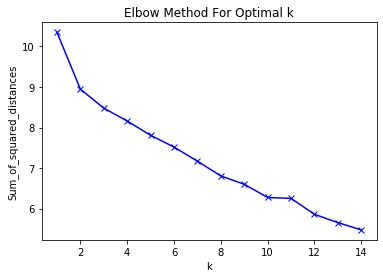

In [30]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

Based on the plot above, we will take k=10 as the optimal value.

In [31]:
# set number of clusters
kclusters = 10

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(cluster)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([0, 0, 3, 5, 0, 7, 7, 0, 0, 3])

Now I will create a DataFrame that includes the cluster of each neighborhood and add in the coordinate data.

In [32]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

merged = neighborhoods

# merge coordinate data with top venue and cluster data
merged = merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood', how="inner")
merged.head()

,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Grand Boulevard,41.813923,-87.617272,0,Coffee Shop,Sports Bar,Art Gallery,Clothing Store,Restaurant,Smoke Shop,Breakfast Spot,Boutique,Lounge,Food
1,Printers Row,41.873787,-87.628900,0,Coffee Shop,Pizza Place,Gym / Fitness Center,Sandwich Place,Hotel,American Restaurant,Indian Restaurant,Deli / Bodega,Music Venue,Tapas Restaurant
2,United Center,41.880683,-87.674185,0,Stadium,Outdoor Sculpture,Hockey Arena,Basketball Stadium,Sports Bar,Restaurant,Sporting Goods Shop,Soccer Field,Brazilian Restaurant,Fried Chicken Joint
3,Humboldt Park,41.905767,-87.704174,0,Park,Food Truck,Lake,Garden,History Museum,Café,Museum,Beach,Doctor's Office,Dog Run
4,Garfield Park,41.882088,-87.715917,8,Botanical Garden,Food,Garden,Park,Trail,Train Station,Doctor's Office,Dog Run,Donut Shop,Dry Cleaner


### Find Chicago cluster that also contains the Gourmet Ghetto

In [33]:
merged.tail()

,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
86,Belmont Cragin,41.931698,-87.768670,3,Mexican Restaurant,Grocery Store,Restaurant,BBQ Joint,Bakery,Thrift / Vintage Store,Discount Store,Gas Station,Department Store,Chinese Restaurant
87,Austin,41.887876,-87.764851,7,Park,Bus Station,Grocery Store,Wings Joint,Construction & Landscaping,Donut Shop,Shoe Repair,Liquor Store,Gym,Intersection
88,Gold Coast,41.906699,-87.625331,0,Beach,Hotel,Italian Restaurant,Café,Coffee Shop,Non-Profit,Bookstore,Snack Place,Shipping Store,Science Museum
89,Boystown,41.943883,-87.649267,0,Gay Bar,Coffee Shop,Japanese Restaurant,Bakery,Bar,Pizza Place,Sushi Restaurant,Mexican Restaurant,Sandwich Place,Spa
90,Gourmet Ghetto,37.879830,-122.269260,0,Coffee Shop,Italian Restaurant,French Restaurant,New American Restaurant,Dessert Shop,Chinese Restaurant,Burger Joint,Deli / Bodega,Tea Room,Bakery


The Gourmet Ghetto is in Cluster 0. Below, we will make a new DataFrame that only contains neighborhoods in the same cluster group as the Gourmet Ghetto.

In [34]:
like_berkeley = merged[merged['Cluster Labels']==0]
print(like_berkeley.shape)
like_berkeley.tail()

(63, 14)


,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
84,Montclare,41.927744,-87.798457,0,Liquor Store,Dive Bar,Wings Joint,Mexican Restaurant,Business Service,Convenience Store,Pizza Place,Moving Target,Electronics Store,Dog Run
85,Old Town,41.896198,-87.655358,0,Gym,Pizza Place,Yoga Studio,Bus Station,Theater,Massage Studio,Bar,Museum,Taco Place,Sushi Restaurant
88,Gold Coast,41.906699,-87.625331,0,Beach,Hotel,Italian Restaurant,Café,Coffee Shop,Non-Profit,Bookstore,Snack Place,Shipping Store,Science Museum
89,Boystown,41.943883,-87.649267,0,Gay Bar,Coffee Shop,Japanese Restaurant,Bakery,Bar,Pizza Place,Sushi Restaurant,Mexican Restaurant,Sandwich Place,Spa
90,Gourmet Ghetto,37.879830,-122.269260,0,Coffee Shop,Italian Restaurant,French Restaurant,New American Restaurant,Dessert Shop,Chinese Restaurant,Burger Joint,Deli / Bodega,Tea Room,Bakery


Since there are 63 rows in our new DataFrame, there are 62 neighborhoods in Chicago that are most similar to the Gourmet Ghetto.

### Map of Chicago neighborhoods by cluster group
Now we will map the Chicago neighborhoods again, this time color-coding each according to the cluster it belongs to.

First, we need to create a new DataFrame in which the last row (the Gourmet Ghetto) is dropped.

In [35]:
chicago_clusters = merged[merged['Neighborhood']!="Gourmet Ghetto"]
chicago_clusters.shape

(88, 14)

Now, let's visualize the clusters in Chicago.

In [36]:
# create map
map_clusters = folium.Map(location=[latitude_chi, longitude_chi], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(chicago_clusters['Latitude'], chicago_clusters['Longitude'], chicago_clusters['Neighborhood'], chicago_clusters['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

Our labels tell us that the red neighborhoods belong to Cluster 0.

### Narrowing the list: Distance from The University of Illinois at Chicago
In order to fulfill the client's second request, we will obtain the coordinates for the University of Illinois at Chicago to determine the distance between the university and each Cluster 0 neighborhood. The Cluster 0 neighborhoods will then be presented in a list in ascending order by distance from the university.

First, we will get the coordinates of the university.

In [37]:
address = 'University of Illinois at Chicago, Chicago, IL, USA'

geolocator = Nominatim(user_agent="chicago_search")
location = geolocator.geocode(address)
latitude_uni = location.latitude
longitude_uni = location.longitude
print('The geograpical coordinate of the university are {}, {}.'.format(latitude_uni, longitude_uni))

The geograpical coordinate of the university are 41.86898915, -87.64856255970184.


Now that we have already used our venue data for Cluster 0 neighborhoods, we will create a new DataFrame with just the neighborhood and the coordinates of each Cluster 0 neighborhood.

In [38]:
cluster_0 = like_berkeley[["Neighborhood", "Latitude", "Longitude"]]
cluster_0.head()

,Neighborhood,Latitude,Longitude
0,Grand Boulevard,41.813923,-87.617272
1,Printers Row,41.873787,-87.628900
2,United Center,41.880683,-87.674185
3,Humboldt Park,41.905767,-87.704174
5,North Lawndale,41.858151,-87.713881


To get the Euclidean distance between the coordinate vectors of each neighborhood and the university, we need to generate numpy arrays and carry out the required math.

In [39]:
x1 = cluster_0["Longitude"].values
x2 = longitude_uni

y1 = cluster_0["Latitude"].values
y2 = latitude_uni

dist_sq = np.square(x2 - x1)  + np.square(y2 - y1) 

distances = np.sqrt(dist_sq)

Now we can convert this array into a new column for our DataFrame.

In [40]:
cluster_0.insert(1, 'Distance from uni', distances)
cluster_0.head()

,Neighborhood,Distance from uni,Latitude,Longitude
0,Grand Boulevard,0.063336,41.813923,-87.617272
1,Printers Row,0.020240,41.873787,-87.628900
2,United Center,0.028165,41.880683,-87.674185
3,Humboldt Park,0.066672,41.905767,-87.704174
5,North Lawndale,0.066212,41.858151,-87.713881


Now we will order the neighborhoods from closest to furthest from the university.

In [41]:
cluster_0 = cluster_0.sort_values(by=["Distance from uni"])
cluster_0 = cluster_0.reset_index(drop=True)
cluster_0.head()

,Neighborhood,Distance from uni,Latitude,Longitude
0,Greektown,0.009595,41.878445,-87.646932
1,Printers Row,0.020240,41.873787,-87.628900
2,East Village,0.025020,41.875562,-87.624421
3,Loop,0.025020,41.875562,-87.624421
4,Little Village,0.025020,41.875562,-87.624421


Based on this result, the client should start their new restaurant in Greektown, Chicago, IL!

Lastly, we can take a quick look at the top 10 venues for a slice of the neighborhoods in Cluster 0 in order to hypothesize what features characterize this set of neighborhoods.

In [42]:
like_berkeley.tail(20)

,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
65,Beverly,41.718153,-87.671767,0,Cosmetics Shop,Boutique,Farmers Market,Martial Arts Dojo,Burger Joint,Italian Restaurant,Bakery,Grocery Store,Park,Ethiopian Restaurant
66,Washington Heights,41.706423,-87.656160,0,Caribbean Restaurant,Cosmetics Shop,American Restaurant,Salon / Barbershop,Park,Yoga Studio,Dog Run,Donut Shop,Dry Cleaner,Eastern European Restaurant
67,Hyde Park,41.794225,-87.592562,0,Sandwich Place,Bookstore,Park,Train Station,Dive Bar,Taco Place,Shopping Mall,Shipping Store,Mexican Restaurant,Middle Eastern Restaurant
68,Bucktown,41.912499,-87.672467,0,Bookstore,Park,Bar,Pub,Pizza Place,Mexican Restaurant,BBQ Joint,Gourmet Shop,Boxing Gym,Sushi Restaurant
70,Wrigleyville,41.947022,-87.656477,0,Bar,Sports Bar,General Entertainment,Sandwich Place,Pizza Place,Restaurant,Dive Bar,Taco Place,Mexican Restaurant,Baseball Stadium
72,Brighton Park,41.818922,-87.698942,0,Grocery Store,Taco Place,Breakfast Spot,Café,Sandwich Place,Burger Joint,Park,Mexican Restaurant,American Restaurant,Clothing Store
73,Mckinley Park,41.831700,-87.673664,0,Diner,Gas Station,Video Game Store,Baseball Field,Discount Store,Burger Joint,Seafood Restaurant,Cantonese Restaurant,Train,Grocery Store
74,East Village,41.875562,-87.624421,0,Coffee Shop,Pizza Place,Sandwich Place,Hotel,Museum,Pub,Boutique,Dance Studio,Art Museum,Theater
75,West Town,41.901421,-87.686166,0,Dive Bar,Grocery Store,Bar,Mexican Restaurant,Bakery,Salon / Barbershop,Steakhouse,Italian Restaurant,Bank,Breakfast Spot
76,Bridgeport,41.837938,-87.651028,0,Chinese Restaurant,Wings Joint,Pharmacy,Pizza Place,Park,Grocery Store,Mobile Phone Shop,Art Gallery,Coffee Shop,Bar


It seems that neighborhoods in Cluster 0 all have a wide range of venues that cater to young professionals, such as restaurants, bars, and a variety of shops. 